In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp
import pprint
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn import metrics
import dtreeviz.trees
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from pprint import pprint
import math



This cell is used to read in the data from the csv file

In [3]:
df = pd.read_csv('inner_data.csv')
column_headers = list(df.columns.values)
len(column_headers)

84

Here we are building the helper functions: <br>
split_data_by_feature, split_data_by_applicant, linear_to_poly_data, provide_best_features, plot_best_features <br>
which will help us to perform different data splits and some optimizations for the models.


In [4]:
def split_data_by_feature(df, feature):
    """
    input: df - dataframe, feature - int
    output: X_train, X_test, y_train, y_test - numpy arrays
    description: This function takes in a dataframe and a feature number and returns the a split of the data into training and testing sets using a specified ratio
                The feature number is the column number (or label) of the feature to be predicted
                """
    data = df.to_numpy()
    data = data[:, 1:]
    data = data[:, 1:]
    X = np.delete(data, feature, axis=1)
    y = data[:, feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def split_data_by_applicant(df, feature):
    """
    input: df - dataframe, feature - int
    output: X_train, X_test, y_train, y_test - numpy arrays
    description: This function takes in a dataframe and a feature number and returns the a split of the data into training and testing sets using a specified ratio
                The feature number is the column number (or label) of the feature to be predicted
                The data is split by applicant, so that all of the data for a given applicant is either in the training set or the testing set
                This is done to optimize the data, since the data for a given applicant is likely to be correlated and is from the same distribution
                """
    applicants = df.Applicant.unique()
    applicants_train, applicants_test = train_test_split(applicants, test_size=0.2, random_state=42)
    data_train = df[df.Applicant.isin(applicants_train)].copy()
    data_test = df[df.Applicant.isin(applicants_test)].copy()
    data_train.drop(columns=['Question','Applicant'], inplace=True)
    data_test.drop(columns=['Question','Applicant'], inplace=True)

    data_train=data_train.to_numpy()
    data_test=data_test.to_numpy()

    X_train, X_test, y_train, y_test = np.delete(data_train, feature, axis=1),np.delete(data_test, feature, axis=1), data_train[:, feature],data_test[:, feature]
    return X_train, X_test, y_train, y_test


def linear_to_poly_data(X_train, X_test, degree):
    """
    input: X_train, X_test - numpy arrays, degree - int
    output: X_train_poly, X_test_poly - numpy arrays, poly_names - list
    description: This function takes in the training and testing data and the degree of the polynomial to be used and returns the polynomial features of the data
                The polynomial features are the original features raised to the powers from 0 to the degree
                The function also returns the names of the polynomial features
                """

    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    poly_names = poly_features.get_feature_names_out()
    return X_train_poly, X_test_poly, poly_names
    

def provide_best_features(X_train_poly, X_test_poly, y_train, y_test, num_feat, thresh=0.1):
    """
    input: X_train_poly, X_test_poly, y_train, y_test - numpy arrays, num_feat - int, thresh - float
    output: top5_indices - list, mse - float, accuracy - float
    description: This function takes in the training and testing data, the number of features to be returned, and the threshold for the accuracy
                The function returns the indices of the top 5 features, the mean squared error of the model, and the accuracy of the model
                The accuracy is the percentage of predictions that are within the threshold of the actual value
                """
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)
    # print("Mean Squared Error:", "{:.4f}".format(mse))
    pred_comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    pred_comparison_df["True/False"] = np.abs(pred_comparison_df["Actual"] - pred_comparison_df["Predicted"]) < thresh        
    # print("Accuracy: ","{:.2f}".format(100*pred_comparison_df["True/False"].value_counts(normalize=True)[0]),"%")
    feature_coefficients = np.argsort(np.abs(model.coef_)) 
    feature_names =linear_to_poly_data(X_train_poly, X_test_poly, 1)[2][:-1]
    # plot_best_features(model.coef_, feature_names)
    top5_indices = feature_coefficients[-num_feat:]
    return top5_indices.tolist(), mse, pred_comparison_df["True/False"].value_counts(normalize=True)[0]


def plot_best_features(model_coef, feature_names):
    """
    input: model_coef - numpy array, feature_names - list
    output: None
    description: This function takes in the coefficients of the model and the names of the features and plots the coefficients of the features
                The function also annotates the features that have a coefficient greater than 0.3 or less than -0.3
                """
    ax = plt.subplots(1,1)[1]
    bars = ax.bar(feature_names, model_coef)

    for i in range(len(bars)):
        height = bars[i].get_height()
        if height>=.3:
            ax.annotate(df.columns[i],
                    xy=(bars[i].get_x() + bars[i].get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
            bars[i].set_color('orange')
        elif height<=-.3:
            ax.annotate(df.columns[i],
                    xy=(bars[i].get_x() + bars[i].get_width() / 2, height),
                    xytext=(0, -3),
                    textcoords="offset points",
                    ha='center', va='top')
            bars[i].set_color('orange')
    ax.axhline(y=0.3, color='r', linestyle='--')
    ax.axhline(y=-0.3, color='r', linestyle='--')
    ax.axhline(y=0, color='black', linestyle='-')

    ax.set_xlabel('Feature Names')
    ax.set_ylabel('Coefficients')
    ax.set_title('Coefficient Bar Chart')
    ax.set_ylim([min(model_coef)-.1, max(model_coef)+.1])
    
    i=0
    ratio = int(math.ceil(len(feature_names)/20))
    for label in ax.xaxis.get_ticklabels():
        if i % ratio != 0: 
            label.set_visible(False)
        i+=1    
    
    plt.show()
    

Here we are building the main functions: <br>
run_model, filter_best_predictions, and get_specific_features <br>
which will help us to run the model, then get the best features that had the best results, and filter features by a given list.


In [5]:
def run_model(df, degree, num_feat, split_func):
    """
    input: df - pandas dataframe, degree - int, num_feat - int, split_func - function
    output: best_features_to_predict - dictionary containing the feature to be predicted as the key and the top 5 features as the value and their corresponding mse and accuracy
    description: This function takes in the dataframe, the degree of the polynomial to be used, the number of features to be returned, and the split function to be used
                The function returns the indices of the top 5 features, the mean squared error of the model, and the accuracy of the model
                The accuracy is the percentage of predictions that are within the threshold of the actual value
                """
    best_features = []
    best_features_to_predict = {}
    for feature in range(df.shape[1]-2):
        # print("FEATURE TO PREDICT: ", feature, df.columns[feature])
        X_train, X_test, y_train, y_test = split_func(df, feature)
        X_train_poly, X_test_poly, poly_names = linear_to_poly_data(X_train, X_test, degree)
        model_eval = provide_best_features(X_train_poly, X_test_poly, y_train, y_test, num_feat)
        top_features = poly_names[model_eval[0]].tolist()
        best_features.append(model_eval[0])

        # print("predict with only TOP ",num_feat," features:")
        X_train_only_best, X_test_only_best = X_train_poly[:,best_features[feature]], X_test_poly[:, best_features[feature]]
        compact_model_eval = provide_best_features(X_train_only_best, X_test_only_best, y_train, y_test, num_feat)
        best_features_to_predict[feature] = {'feature name':df.columns[feature],'predictors names':top_features,'feature numbers':model_eval[0], 'mse':model_eval[1],'accuracy':model_eval[2],'compact model mse': compact_model_eval[1],'compact model accuracy': compact_model_eval[2], 'ratio':compact_model_eval[2]/model_eval[2]}
        # print("\n")
    # pprint(best_features_to_predict)
    return best_features_to_predict

def filter_best_predictions(model, ratio, thresh):
    """
    input: model - dictionary, ratio - float, thresh - float
    output: filtered_features - dictionary
    description: This function takes in the model, the ratio of the compact model accuracy to the model accuracy, and the threshold of the model accuracy
                The function returns a dictionary of the features that have a compact model accuracy that is greater than the model accuracy and the model accuracy is greater than the threshold
                """
    filtered_features = {}
    for feature in model:
        current = model[feature]
        if current["compact model accuracy"]/current["accuracy"] >= ratio and current["accuracy"]>thresh:
            filtered_features[feature] = current
    # pprint(filtered_features)
    return filtered_features


def get_specific_features(model, features):
    """
    input: model - dictionary, features - list
    output: filtered_features - dictionary
    description: This function takes in the model and a list of features
                The function returns a dictionary of the features that are in the list of features
                """
    filtered_features = {}
    for feature in range(len(model)):
        if model[feature]["feature name"] in features:
            filtered_features[feature]=model[feature]
    return filtered_features


We shall run the model and check for results:

In [6]:
# this cell is used to run the model using split_data_by_feature and get the model for each feature
degree = 1
num_feat = 5
model_by_feature = run_model(df,degree, num_feat, split_data_by_feature)

In [7]:
# this cell is used to filter the model by the ratio and threshold, and get the all the features that have a compact model accuracy that holds the ratio and threshold
thresh = 0.90
ratio = 0.90
best_by_feature = filter_best_predictions(model_by_feature, ratio, thresh)

len(best_by_feature)

15

In [14]:
# best_by_feature

In [9]:
# this cell is used to run the model using split_data_by_applicant and get the model for each feature
degree = 1
num_feat = 2
model_by_applicant = run_model(df,degree, num_feat, split_data_by_applicant)

In [10]:
# this cell is used to filter the model by the ratio and threshold, and get the all the features that have a compact model accuracy that holds the ratio and threshold
thresh = 0.90
ratio = 0.90
best_by_applicant = filter_best_predictions(model_by_applicant,ratio, thresh)

len(best_by_applicant)

14

Next we set some complex traits that we want to predict, and check if they are in the best_by_feature dictionary


In [15]:
# List of complex traits to check for:
complex_traits = [
    "triumphant",
    "tolerant",
    "proactivity",
    "persistent",
    "independent",
    "pleased",
    "organized",
    "go-getter"
]

thresh = 0.90
ratio = 0.90
complex_features = get_specific_features(model_by_feature, complex_traits)
filtered_complex = filter_best_predictions(complex_features, ratio, thresh)
# pprint(complex_features)
# pprint(filtered_complex)
print("Predicted ", len(filtered_complex), " out of ", len(
    complex_features), " complex features above the threshhold")


Predicted  8  out of  8  complex features above the threshhold


In [12]:
df2 = pd.DataFrame.from_dict(filtered_complex, orient='index')
df2

,feature name,predictors names,feature numbers,mse,accuracy,compact model mse,compact model accuracy,ratio
39,go-getter,"[x17, x28, x58, x27, x79]","[18, 29, 59, 28, 80]",0.000740,0.989899,0.001081,0.989899,1.000000
43,independent,"[x51, x39, x61, x9, x58]","[52, 40, 62, 10, 59]",0.000717,1.000000,0.001853,0.959596,0.959596
49,organized,"[x15, x59, x27, x39, x42]","[16, 60, 28, 40, 43]",0.002312,0.939394,0.002920,0.909091,0.967742
53,persistent,"[x59, x27, x53, x39, x79]","[60, 28, 54, 40, 80]",0.002932,0.949495,0.004831,0.898990,0.946809
54,pleased,"[x59, x58, x9, x43, x53]","[60, 59, 10, 44, 54]",0.003198,0.949495,0.006508,0.929293,0.978723
59,proactivity,"[x52, x9, x61, x39, x43]","[53, 10, 62, 40, 44]",0.001321,0.989899,0.002770,0.939394,0.948980
79,tolerant,"[x14, x27, x79, x39, x60]","[15, 28, 80, 40, 61]",0.004470,0.919192,0.008595,0.919192,1.000000
80,triumphant,"[x53, x27, x62, x42, x39]","[54, 28, 63, 43, 40]",0.000572,0.989899,0.000681,0.989899,1.000000


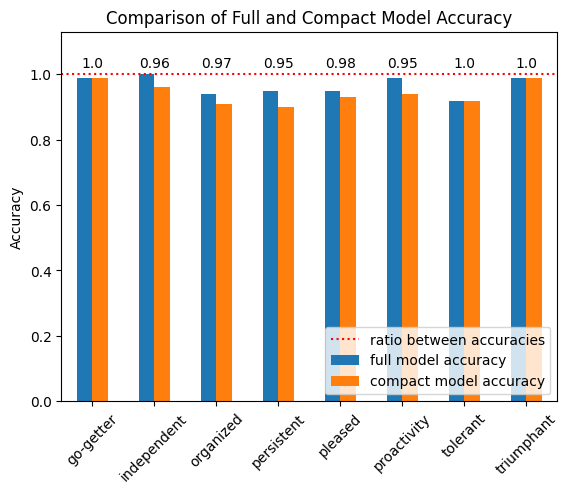

In [16]:
def plot_full_vs_compact_resutls(df):
    # document plot_full_vs_compact_resutls function
    """"
    input: df - dataframe
    output: None
    description: This function takes in a dataframe and plots a bar graph of the accuracy and compact model accuracy of each feature
                """
    ax = df.plot.bar(x='feature name', y=['accuracy', 'compact model accuracy'], rot=45)
    ax.set_xlabel(None)
    ax.set_ylabel('Accuracy')
    ax.set_title('Comparison of Full and Compact Model Accuracy')
    ax.set_ylim([0, 1.13])
    y_value = 1
    ax.axhline(y=y_value, color='red', linestyle='dotted')
    ax.legend([ 'ratio between accuracies','full model accuracy', 'compact model accuracy'], loc='lower right')
    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i, 1.02, y[i], ha = 'center')
    addlabels(df['feature name'].to_list(), list(np.around(np.array(df['ratio'].to_list()),2)))
    plt.show()

plot_full_vs_compact_resutls(df2)
